## Importing libraries

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import py21cmfast as p21c

## Cosmological Parameters (Default is used when no input is specified)

In [29]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, etc.

In [30]:
BOX_LEN=300  # Box length
DIM=600      # Number of Voxels for hight resolution 
HII_DIM=300  # Number of Voxels for low resolution 

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,
    DIM=DIM,
    HII_DIM=HII_DIM
)

## Creating initial conditions box

In [31]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Cube Blurring Function

In [49]:
def Square_Blurring(box, radius, iteration):
    box = box.copy()  # make copy of input box to have a separate box
    for i in range(iteration):
        np.random.seed()  # set seed to a randome number
        
        rand_coord = np.random.randint(radius, BOX_LEN-1-radius, size=3)  # ensure that the random center point won't be at the edge of the cube
        
        cube_region = box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1]
        
        neutral_mean = np.mean(cube_region)
        
        box[rand_coord[0]-radius:rand_coord[0]+radius+1, rand_coord[1]-radius:rand_coord[1]+radius+1, rand_coord[2]-radius:rand_coord[2]+radius+1] = neutral_mean
    return box

## Sphere Blurring Function

# Check is everything is np.array

In [300]:
def Sphere_Blurring(box, radius, iteration):
    box = box.copy()  # make copy of input box to have a separate box
    inside_sphere_mean_data = []
    for i in range(iteration):
        np.random.seed()  # set seed to a randome number
        
        rand_coord = np.random.randint(radius, BOX_LEN-1-radius, size=3)  # ensure that the random center point won't be at the edge of the cube
#         rand_coord = np.array([0, 0, 0])
    
#         print(rand_coord)
        
        x1 = rand_coord[0]-radius
        x2 = rand_coord[0]+radius+1
        y1 = rand_coord[1]-radius
        y2 = rand_coord[1]+radius+1
        z1 = rand_coord[2]-radius
        z2 = rand_coord[2]+radius+1
        
        if x1 < 0:
            x_inds = np.r_[(x1+box.shape[0]):box.shape[0], 0:x2]
        elif x2 > box.shape[0]:
            x_inds = np.r_[x1:box.shape[0], 0:(x2-box.shape[0])]
        else:
            x_inds = np.r_[x1:x2]
            
        if y1 < 0:
            y_inds = np.r_[(y1+box.shape[1]):box.shape[1], 0:y2]
        elif y2 > box.shape[1]:
            y_inds = np.r_[y1:box.shape[1], 0:(y2-box.shape[1])]
        else:
            y_inds = np.r_[y1:y2]
            
        if z1 < 0:
            z_inds = np.r_[(z1+box.shape[2]):box.shape[2], 0:z2]
        elif z2 > box.shape[2]:
            z_inds = np.r_[z1:box.shape[2], 0:(z2-box.shape[2])]
        else:
            z_inds = np.r_[z1:z2]
                         
        idx = np.ix_(x_inds, y_inds, z_inds)
        
        cube_region = box[idx]
        
#         print(np.shape(cube_region))
        
        keys_index_x = np.arange(-0.5*(np.shape(cube_region)[0]-1), 0.5*(np.shape(cube_region)[0]+1))
        keys_index_y = np.arange(-0.5*(np.shape(cube_region)[1]-1), 0.5*(np.shape(cube_region)[1]+1))
        keys_index_z = np.arange(-0.5*(np.shape(cube_region)[2]-1), 0.5*(np.shape(cube_region)[2]+1))
        
        keys_x, keys_y, keys_z = np.meshgrid(keys_index_x, keys_index_y, keys_index_z, indexing='ij')

        dist_frm_coord = np.sqrt((keys_x)**2 + (keys_y)**2 + (keys_z)**2)
        
#         print(keys_index_x)
#         print(dist_frm_coord.shape)
        
        sphere_condition =  dist_frm_coord <= radius
#         sphere_condition1 =  dist_frm_coord <= 0.25*radius
#         sphere_condition2 =  np.logical_and(dist_frm_coord <= 0.5*radius, dist_frm_coord > 0.25*radius)
#         sphere_condition3 =  np.logical_and(dist_frm_coord <= 0.75*radius, dist_frm_coord > 0.5*radius)
#         sphere_condition4 =  np.logical_and(dist_frm_coord <= radius, dist_frm_coord > 0.75*radius)
        
        inside_sphere_mean = np.mean(cube_region[sphere_condition])  # slicing shaped array by condition will ravel the array
        
        inside_sphere_mean_data = np.append(inside_sphere_mean_data, inside_sphere_mean)
#         cube_region = np.where(sphere_condition, inside_sphere_mean, cube_region)

#         cube_region = np.where(sphere_condition1, inside_sphere_mean, cube_region)
#         cube_region = np.where(sphere_condition2, 0.75*inside_sphere_mean, cube_region)
#         cube_region = np.where(sphere_condition3, 0.5*inside_sphere_mean, cube_region)
#         cube_region = np.where(sphere_condition4, 0.25*inside_sphere_mean, cube_region)
        
#         box[idx] = cube_region  
#     return box
    return np.array(inside_sphere_mean_data)

## Make the colorbar fit with the plot in the figures

In [34]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, label="Neutral Fraction")
    plt.sca(last_axes)
    return cbar

## Creating Ionize box

In [179]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

## Blurring the box

In [327]:
np.random.seed()
rand_box = np.random.rand(299,299,299)
Sphere_blurred = Sphere_Blurring(box=ionized, radius=50, iteration=10**3)
# Sphere_blurred = Sphere_Blurring(box=np.zeros((7,7,7)), radius=2, iteration=1)

In [329]:
Sphere_blurred

array([0.20020708, 0.20016544, 0.17701535, 0.14627543, 0.12342798,
       0.20612741, 0.2776891 , 0.23676476, 0.21287195, 0.28521904,
       0.18826762, 0.16897163, 0.12050963, 0.24830475, 0.17865683,
       0.13995436, 0.16888492, 0.16845828, 0.26682937, 0.12754513,
       0.17981908, 0.214406  , 0.17490008, 0.13704021, 0.32670274,
       0.12979427, 0.22780731, 0.29580474, 0.13987213, 0.342549  ,
       0.32262912, 0.3105706 , 0.21058317, 0.11501727, 0.19308649,
       0.22653788, 0.10024261, 0.17199591, 0.08713052, 0.16698796,
       0.16156599, 0.29030532, 0.27062818, 0.1028688 , 0.1359883 ,
       0.18642896, 0.0916563 , 0.14499789, 0.15875743, 0.15794688,
       0.22388251, 0.26509973, 0.1315484 , 0.10869135, 0.21490164,
       0.1261735 , 0.06397431, 0.19314235, 0.31695464, 0.14095604,
       0.2735135 , 0.22502072, 0.11267741, 0.23079886, 0.0808837 ,
       0.19386213, 0.23803972, 0.31327495, 0.20859715, 0.12998849,
       0.19635841, 0.22870004, 0.25246933, 0.22383098, 0.28106

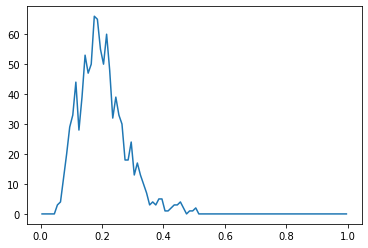

In [330]:
bin_edges = np.linspace(0,1,101) # 100 bins from 0-1
hist, _ = np.histogram(Sphere_blurred, bins=bin_edges)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.plot(bin_centers, hist)

In [316]:
np.mean(Sphere_blurred[100:200, 100:200, 100:200]) - np.mean(rand_box[100:200, 100:200, 100:200])

IndexError: too many indices for array

In [286]:
np.mean(Sphere_blurred[:, :, :] == rand_box[:, :, :]) - (1 - (((4/3)*np.pi*(50.5)**3) / 300**3))

0.00040337815953372935

In [320]:
1 - (((4/3)*np.pi*(50.5)**3) / 300**3)

0.9800198391815665

In [269]:
np.std(Sphere_blurred[100:200, 100:200, 100:200]) - np.std(rand_box[100:200, 100:200, 100:200])

0.0

In [288]:
"{:.2e}".format(2**64)

'1.84e+19'

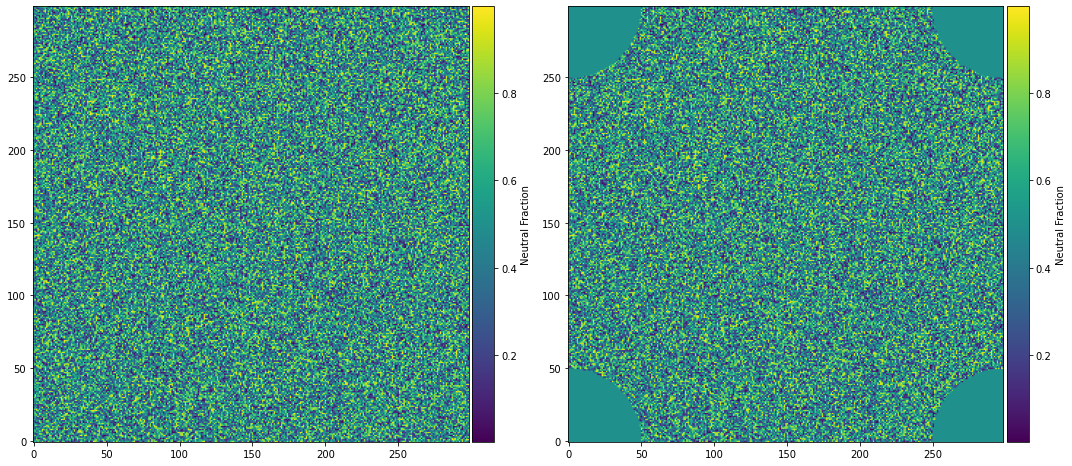

In [291]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(rand_box[0,:,:], origin='lower')
colorbar(img1)

img2 = ax2.imshow(Sphere_blurred[0,:,:], origin='lower')
colorbar(img2)

plt.tight_layout(h_pad=1)

## x, y, z slices of the blurred box

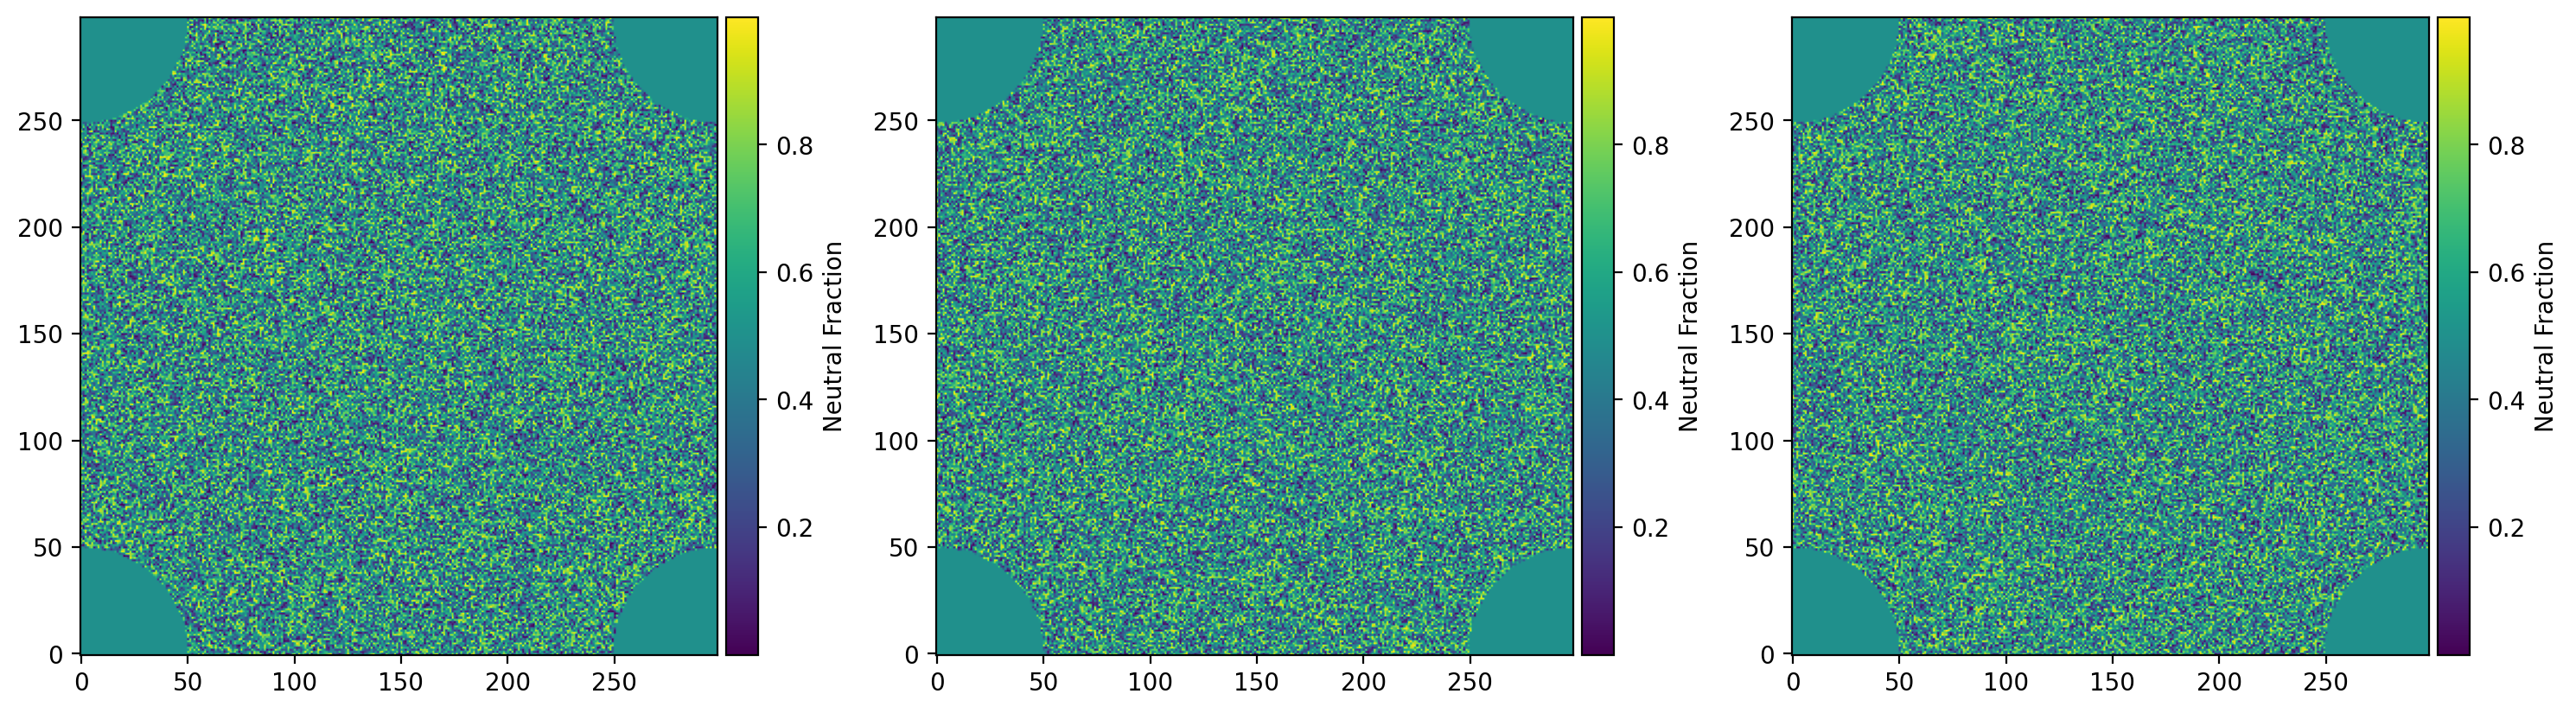

In [294]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,15), dpi=200)

img1 = ax1.imshow(Sphere_blurred[0,:,:], origin='lower')
colorbar(img1)

img2 = ax2.imshow(Sphere_blurred[:,0,:], origin='lower')
colorbar(img2)

img3 = ax3.imshow(Sphere_blurred[:,:,0], origin='lower')
colorbar(img3)

plt.tight_layout(h_pad=1)

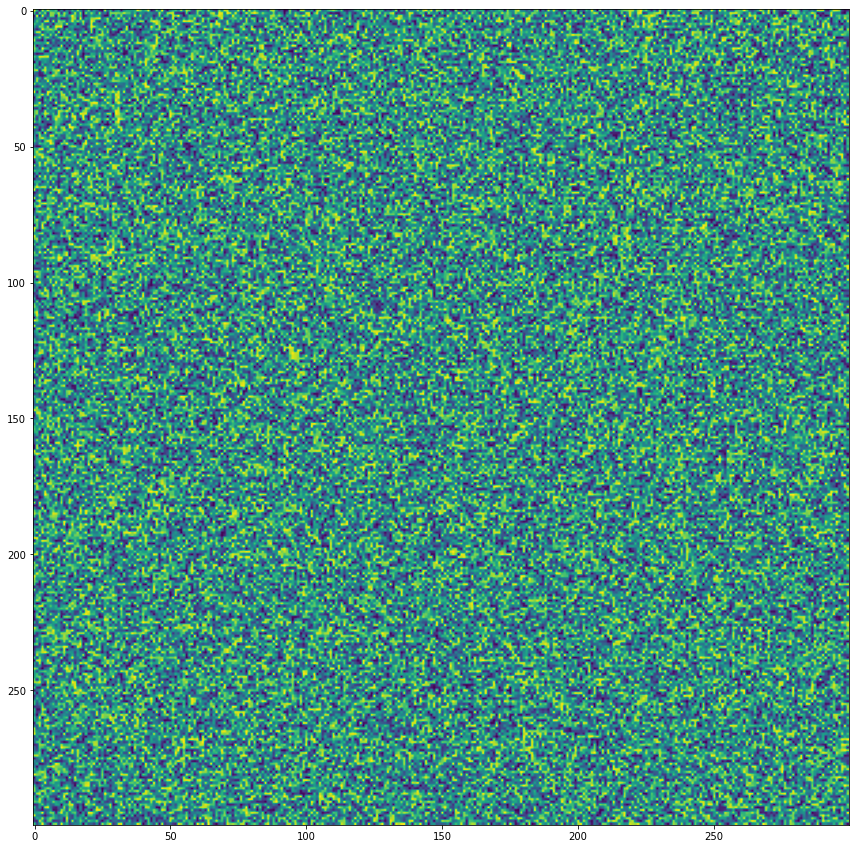

In [232]:
plt.figure(figsize=(15,15))
plt.imshow(np.random.rand(300,300,300)[:,:,149])

## unblurred and blurred side by side comparison

[0 0 0]
(281, 281, 281)
[-140. -139. -138. -137. -136. -135. -134. -133. -132. -131. -130. -129.
 -128. -127. -126. -125. -124. -123. -122. -121. -120. -119. -118. -117.
 -116. -115. -114. -113. -112. -111. -110. -109. -108. -107. -106. -105.
 -104. -103. -102. -101. -100.  -99.  -98.  -97.  -96.  -95.  -94.  -93.
  -92.  -91.  -90.  -89.  -88.  -87.  -86.  -85.  -84.  -83.  -82.  -81.
  -80.  -79.  -78.  -77.  -76.  -75.  -74.  -73.  -72.  -71.  -70.  -69.
  -68.  -67.  -66.  -65.  -64.  -63.  -62.  -61.  -60.  -59.  -58.  -57.
  -56.  -55.  -54.  -53.  -52.  -51.  -50.  -49.  -48.  -47.  -46.  -45.
  -44.  -43.  -42.  -41.  -40.  -39.  -38.  -37.  -36.  -35.  -34.  -33.
  -32.  -31.  -30.  -29.  -28.  -27.  -26.  -25.  -24.  -23.  -22.  -21.
  -20.  -19.  -18.  -17.  -16.  -15.  -14.  -13.  -12.  -11.  -10.   -9.
   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.    0.    1.    2.    3.
    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.   15.
   16.   17.   18.   19.   

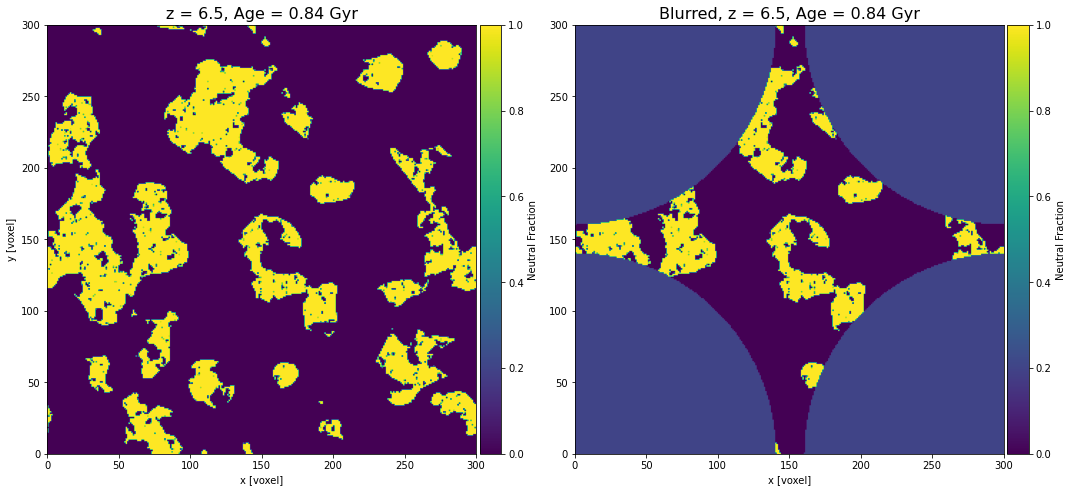

In [240]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

img1 = ax1.imshow(ionized[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax1.set_title(f"z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax1.set_ylabel("y [voxel]")
ax1.set_xlabel("x [voxel]")
colorbar(img1)


img2 = ax2.imshow(Sphere_Blurring(ionized, 140, 1)[:, :, 0], extent=(0,BOX_LEN,0,BOX_LEN), origin='lower')
ax2.set_title(f"Blurred, z = {z}, Age = {cosmo_params.cosmo.age(z):.2f}", fontsize=16)
ax2.set_xlabel("x [voxel]")
colorbar(img2)

plt.tight_layout(h_pad=1)